# SVM
5月2日（土）

## データセット

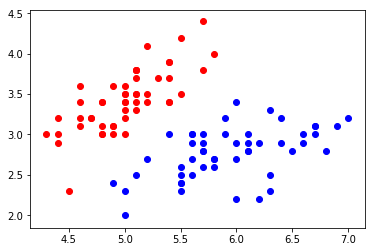

In [2]:
from utility import *

mydata = MyData(data_type='clf')
mydata.plot_data()

In [70]:
X, y = mydata.get_dataset()
# SVMなのでラベルを-1と1に変換する
y = np.where(y==0, -1, y)

# sklearnの線形svm

In [126]:
from sklearn.svm import SVC

clf = SVC(random_state=42, kernel='rbf', C=1, gamma=100)
clf.fit(X, y)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100, kernel='rbf',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [5]:
coef = (clf.dual_coef_ @ clf.support_vectors_)[0]
intercept = clf.intercept_
print(f'coef:{coef} intercept:{intercept}')

coef:[ 2.22720466 -2.24959915] intercept:[-4.9417852]


In [6]:
clf.support_vectors_

array([[4.9, 3. ],
       [5.7, 3.8],
       [5.4, 3.4],
       [5. , 3. ],
       [5.4, 3.4],
       [5.5, 3.5],
       [4.5, 2.3],
       [4.8, 3. ],
       [4.9, 2.4],
       [5.2, 2.7],
       [5.6, 3. ],
       [5.9, 3.2],
       [5.4, 3. ],
       [6. , 3.4],
       [5.6, 3. ],
       [5.1, 2.5]])

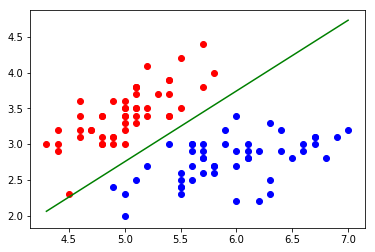

In [7]:
mydata.plot_boundary(coef, intercept)

# 自力で実装

$$
L(\boldsymbol{\alpha}) = \boldsymbol{\alpha}^T \boldsymbol{1} - \frac{1}{2} \boldsymbol{\alpha}^T \boldsymbol{H} \boldsymbol{\alpha} - \frac{1}{2} \beta \boldsymbol{\alpha}^T \boldsymbol{t} \boldsymbol{t}^T \boldsymbol{\alpha}\\
\\
\frac{\partial L}{\partial \boldsymbol{\alpha}} = \boldsymbol{1} - H \boldsymbol{\alpha} - \beta \boldsymbol{t} \boldsymbol{t}^T \boldsymbol{\alpha}\\
\\
\frac{\partial L}{\partial {\beta}} = -\frac{1}{2} \boldsymbol{\alpha}^T \boldsymbol{t} \boldsymbol{t}^T \boldsymbol{\alpha}
$$

In [146]:
class MyLinearSVM():
    def __init__(self, kernel='linear', max_iter=1000, gamma='scale', C=1.0):
        self.max_iter = max_iter
        self.kernel = kernel
        self.gamma = gamma
        self.C = C
        
    def __kernel(self, X):
        n = len(X)
        if self.kernel == 'rbf':
            if self.gamma == 'scale':
                gamma = 1 / (X.shape[1] * X.var())
            else:
                gamma = self.gamma
            K = np.array([[0 for i in range(n)] for j in range(n)])
            for i in range(n):
                for j in range(n):
                    K[i][j] = np.exp(-gamma * np.linalg.norm(X[i] - X[j]))
        elif self.kernel == 'linear':
            K = X @ X.T
        return K
        
    def fit(self, X, y):
        sample_size = len(X)
        alpha = np.zeros(sample_size)
        beta = 1.0
        eta_al = 0.0001
        eta_be = 0.1
        tt = np.c_[y] @ np.c_[y].T
        H = (tt * self.__kernel(X))
        
        for itr in range(self.max_iter):
            tmp_alpha = np.copy(alpha)
            delta = np.ones(sample_size) - H @ alpha - beta * tt @ alpha
            alpha += eta_al * delta
            beta += 0.5 * eta_be * (tmp_alpha.T @ y) ** 2

        index = (0 < alpha) & (alpha < self.C)
        self.coef_ = (alpha * y).T @ X
        self.intercept_ = (y[index] - X[index] @ self.coef_).mean()
    
    def predict(self, X):
        tmp = (X @ self.coef_ +self.intercept_ > 0)
        ans = np.where(tmp==0, -1, tmp)
        return ans
    
    def score(self, X, y):
        y_pred = self.predict(X)
        ans = (y == y_pred).sum() / len(y)
        return ans

In [147]:
X, y = mydata.get_dataset()
# SVMなのでラベルを-1と1に変換する
y = np.where(y==0, -1, y)
mclf = MyLinearSVM(kernel='rbf', max_iter=1000, gamma=1, C=0.1)
mclf.fit(X, y)
mclf.score(X, y)

0.98

In [118]:
x1[(4.5 < x1) & (x1 < 4.8) ]

array([4.51818182, 4.54545455, 4.57272727, 4.6       , 4.62727273,
       4.65454545, 4.68181818, 4.70909091, 4.73636364, 4.76363636,
       4.79090909])

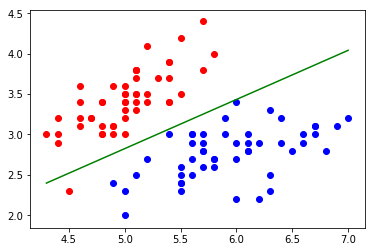

In [110]:
mydata.plot_boundary(mclf.coef_, mclf.intercept_)

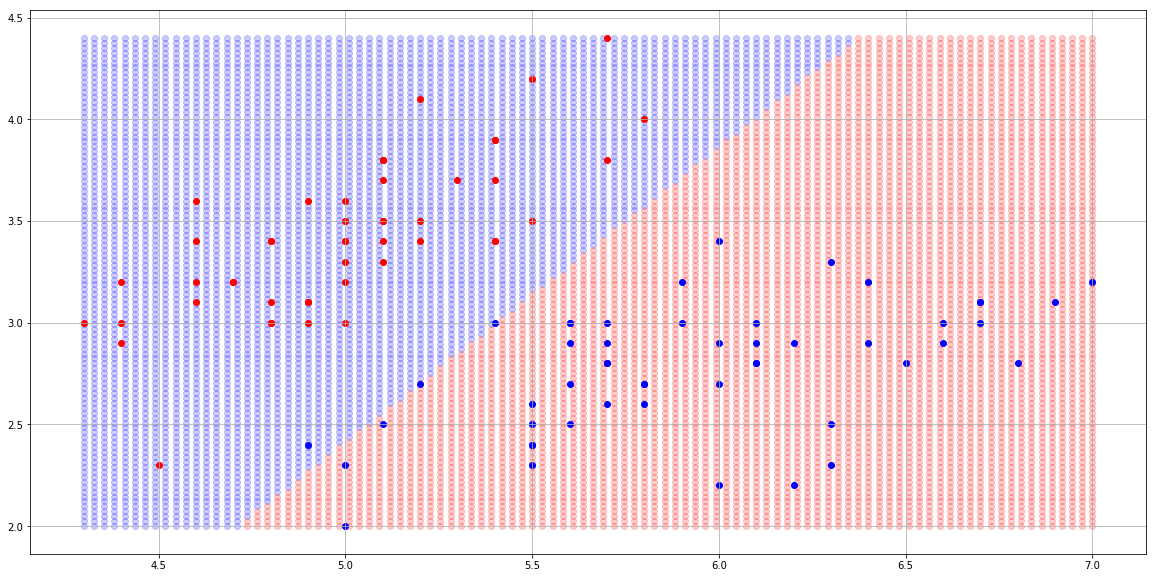

In [148]:
X, y = mydata.get_dataset()

plt.figure(figsize=(20,10))
# 境界線プロット用の格子状データを生成
x1_min = X[:, 0].min()
x1_max = X[:, 0].max()
x2_min = X[:, 1].min()
x2_max = X[:, 1].max()
x1 = np.linspace(x1_min, x1_max, 100)
x2 = np.linspace(x2_min, x2_max, 100)
X1, X2 = np.meshgrid(x1, x2)
plot_X = np.c_[X1.ravel(), X2.ravel()]

plot_y = mclf.predict(plot_X)

plt.scatter(plot_X.T[0][plot_y <= 0], plot_X.T[1][plot_y <= 0], marker='o', color="blue", alpha=0.2)
plt.scatter(plot_X.T[0][plot_y > 0], plot_X.T[1][plot_y > 0], marker='o', color="red", alpha=0.2)
plt.grid()

# y_min = -1 * coef[0] / coef[1] * x_min - intercept / coef[1]
# y_max = -1 * coef[0] / coef[1] * x_max - intercept / coef[1]
plt.scatter(X[y==0][:, 0], X[y==0][:, 1], color='red')
plt.scatter(X[y==1][:, 0], X[y==1][:, 1], color='blue')
# plt.plot([x_min, x_max], [y_min, y_max], color='green')